In [1]:
# Reconstruction error for cell shown in FigureMorphing

In [2]:
!pwd
!date

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/FigureMorphingExt
Mon Mar 28 22:06:07 PDT 2022


In [3]:
import os
import sys
import importlib
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from skimage import io as skio
import matplotlib.pyplot as plt
from aicscytoparam import cytoparam
from aicsshparam import shtools, shparam
from aicsimageio import AICSImage, writers
from cvapipe_analysis.tools import io, viz, general, controller, shapespace, plotting
from cvapipe_analysis.steps.compute_features.compute_features_tools import FeatureCalculator
from vtk import util
sys.path.insert(1, '../tools')
import common

In [4]:
# Controller form cvapipe_analysis
path_config = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/")
control = controller.Controller(general.load_config_file(path_config))
print(control.get_staging())

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_variance


In [5]:
device = io.LocalStagingIO(control)
df = device.load_step_manifest("preprocessing")
print(df.shape)

(202847, 1290)


In [6]:
# Cell used
index = 230883# 438826#
row = df.loc[index]

In [7]:
producer = io.DataProducer(control)
producer.set_row(row)
producer.load_single_cell_data()
producer.align_data()

In [8]:
nuc = (producer.data_aligned[3]>0).astype(np.uint8)
mem = (producer.data_aligned[4]>0).astype(np.uint8)

In [10]:
(coeffs_mem, _), (mem, mesh_mem, _, centroid_mem) = shparam.get_shcoeffs(
    image=mem,
    lmax=control.get_lmax(),
    sigma=control.get_sigma(),
    alignment_2d=False
)

(coeffs_nuc, _), (nuc, mesh_nuc, _, centroid_nuc) = shparam.get_shcoeffs(
    image=nuc,
    lmax=control.get_lmax(),
    sigma=control.get_sigma(),
    alignment_2d=False
)

In [72]:
nuc = nuc.astype(np.uint8)
mem = mem.astype(np.uint8)
instance = np.stack([nuc, mem, producer.data_aligned[2], producer.data_aligned[-1]], axis=0).astype(np.uint16)

In [73]:
r = util.numpy_support.vtk_to_numpy(mesh_mem.GetPoints().GetData())+np.array(centroid_mem).reshape(1,3)
mesh_mem = shtools.update_mesh_points(mesh_mem, r[:,0], r[:,1], r[:,2])

In [74]:
shtools.save_polydata(mesh_mem, "FigureMorphingExt2_3Dcell_mem.vtk")
skio.imsave("FigureMorphingExt2_3Dcell_gfp.tif", instance[-2])
skio.imsave("FigureMorphingExt2_3Dcell_seg.tif", instance[-1])

/tmp/ipykernel_699/1449878875.py:2: UserWarning: FigureMorphingExt2_3Dcell_gfp.tif is a low contrast image
  skio.imsave("FigureMorphingExt2_3Dcell_gfp.tif", instance[-2])
/tmp/ipykernel_699/1449878875.py:3: UserWarning: FigureMorphingExt2_3Dcell_seg.tif is a low contrast image
  skio.imsave("FigureMorphingExt2_3Dcell_seg.tif", instance[-1])


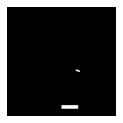

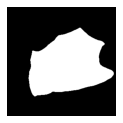

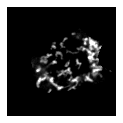

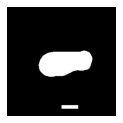

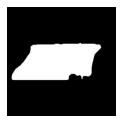

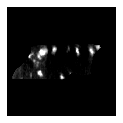

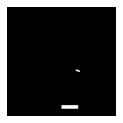

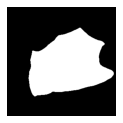

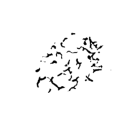

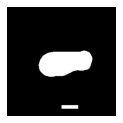

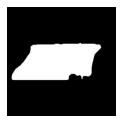

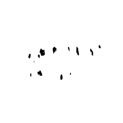

In [87]:
importlib.reload(common)
for plane, mode in zip(["z", "y"], [{"nuc": "top_nuc","mem": "top_nuc","gfp": "top_nuc"}, {"nuc": "center_nuc","mem": "center_nuc","gfp": "center_nuc"}]):
    proj = common.Projector(instance[[0,1,2]], mask_on=True)
    proj.set_projection_mode(ax=plane, mode=mode)
    proj.set_gfp_percentiles([40, 98], local=True)
    proj.set_gfp_colormap("gray")
    proj.project(save=f"FigureMorphingExt2_3Dcell_gfp_{plane}", scale_bar={"pixel_size":0.108, "length":5})
    
importlib.reload(common)
for plane, mode in zip(["z", "y"], [{"nuc": "top_nuc","mem": "top_nuc","gfp": "top_nuc"}, {"nuc": "center_nuc","mem": "center_nuc","gfp": "center_nuc"}]):
    proj = common.Projector(instance[[0,1,3]], mask_on=True)
    proj.set_projection_mode(ax=plane, mode=mode)
    proj.set_gfp_percentiles([20, 98], local=True)
    proj.set_gfp_colormap("binary")
    proj.project(save=f"FigureMorphingExt2_3Dcell_seg_{plane}", scale_bar={"pixel_size":0.108, "length":5})

In [78]:
importlib.reload(cytoparam)
niso = control.get_number_of_interpolating_points()

coords_param, coeffs_centroid = cytoparam.parameterize_image_coordinates(
    seg_mem=mem,
    seg_nuc=nuc,
    lmax=control.get_lmax(),
    nisos=[niso, niso]
)

coeffs_mem, centroid_mem, coeffs_nuc, centroid_nuc = coeffs_centroid

rep = cytoparam.parameterization_from_shcoeffs(
    coeffs_mem=coeffs_mem,
    centroid_mem=centroid_mem,
    coeffs_nuc=coeffs_nuc,
    centroid_nuc=centroid_nuc,
    nisos=[niso, niso],
    images_to_probe=[("gfp", instance[-2]), ("seg", instance[-1])]
).data.squeeze()

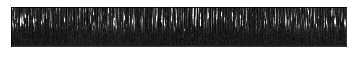

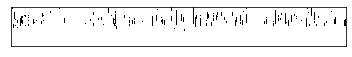

In [79]:
fig, ax = plt.subplots(1,1)
ax.imshow(rep[0,:,::15], cmap="gray", origin="lower", interpolation="nearest", vmin=400, vmax=550)
ax.set_xticks([]); ax.set_yticks([])
plt.savefig(f"FigureMorphingExt2_rep_gfp.png", dpi=150)
plt.show()

fig, ax = plt.subplots(1,1)
ax.imshow(rep[1,:,::15], cmap="binary", origin="lower", interpolation="nearest")
ax.set_xticks([]); ax.set_yticks([])
plt.savefig(f"FigureMorphingExt2_rep_seg.png", dpi=150)
plt.show()

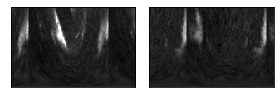

In [80]:
n=1000
fig, axs = plt.subplots(1,2, figsize=(4,4))
axs[0].imshow(rep[0,:,500:600], cmap="gray", vmin=400, vmax=550, origin="lower")
axs[1].imshow(rep[0,:,6500:6600], cmap="gray", vmin=400, vmax=550, origin="lower")
[ax.set_xticks([]) for ax in axs]
[ax.set_yticks([]) for ax in axs]
plt.tight_layout()
fname = f"FigureMorphingExt2_rep_gfp_parts.png"
plt.savefig(fname, dpi=150)
plt.show()

In [88]:
# Reconstruct image from representation
morphed_gfp = cytoparam.morph_representation_on_shape(
    img=nuc+mem,
    param_img_coords=coords_param,
    representation=rep[0]
)

morphed_seg = cytoparam.morph_representation_on_shape(
    img=nuc+mem,
    param_img_coords=coords_param,
    representation=rep[1]
)

In [89]:
instance_rec = np.stack([nuc, mem, morphed_gfp, morphed_seg], axis=0).astype(np.uint16)

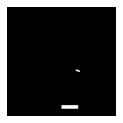

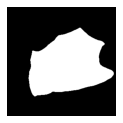

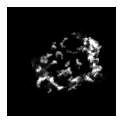

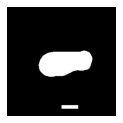

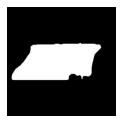

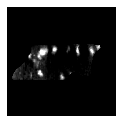

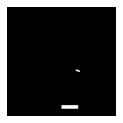

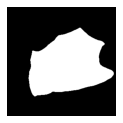

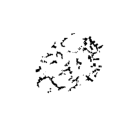

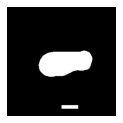

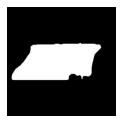

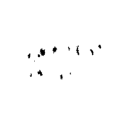

In [92]:
for plane, mode in zip(["z", "y"], [{"nuc": "top_nuc","mem": "top_nuc","gfp": "top_nuc"}, {"nuc": "center_nuc","mem": "center_nuc","gfp": "center_nuc"}]):
    proj = common.Projector(instance_rec[[0,1,2]])
    proj.set_projection_mode(ax=plane, mode=mode)
    proj.set_gfp_percentiles([40, 98], local=True)
    proj.set_gfp_colormap("gray")
    proj.project(save=f"FigureMorphingExt2_3Dcell_rec_gfp_{plane}", scale_bar={"pixel_size":0.108, "length":5})
    
for plane, mode in zip(["z", "y"], [{"nuc": "top_nuc","mem": "top_nuc","gfp": "top_nuc"}, {"nuc": "center_nuc","mem": "center_nuc","gfp": "center_nuc"}]):
    proj = common.Projector(instance_rec[[0,1,3]])
    proj.set_projection_mode(ax=plane, mode=mode)
    proj.set_gfp_percentiles([20, 98], local=True)
    proj.set_gfp_colormap("binary")
    proj.project(save=f"FigureMorphingExt2_3Dcell_rec_seg_{plane}", scale_bar={"pixel_size":0.108, "length":5})

In [152]:
# Voxel-wise Pearson correlation between original and reconstruction
valids = np.where(mem)
print(f"GFP correlation: {np.corrcoef(instance[-2][valids], instance_rec[-2][valids])[0,1]:.2f}")
print(f"SEG correlation: {np.corrcoef(instance[-1][valids], instance_rec[-1][valids])[0,1]:.2f}")

GFP correlation: 0.91
SEG correlation: 0.70


In [139]:
# View of the sparse encoding from PILR
instance_sparse = instance_rec.copy()
instance_sparse[2] = 0
instance_sparse[3] = 0

In [140]:
x = coords_param[0].flatten().astype(int).tolist()
y = coords_param[1].flatten().astype(int).tolist()
z = coords_param[2].flatten().astype(int).tolist()
instance_sparse[2,z,y,x] = rep[0].flatten().astype(int)
instance_sparse[3,z,y,x] = rep[1].flatten().astype(int)

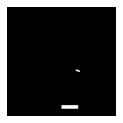

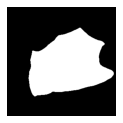

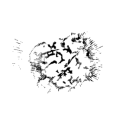

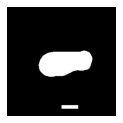

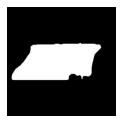

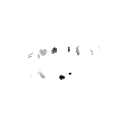

In [150]:
# for plane, mode in zip(["z", "y"], [{"nuc": "top_nuc","mem": "top_nuc","gfp": "top_nuc"}, {"nuc": "center_nuc","mem": "center_nuc","gfp": "center_nuc"}]):
#     proj = common.Projector(instance_sparse[[0,1,2]])
#     proj.set_projection_mode(ax=plane, mode=mode)
#     proj.set_gfp_percentiles([40, 98], local=True)
#     proj.set_gfp_colormap("gray")
#     proj.project(save=f"FigureMorphingExt2_3Dcell_sparse_rec_gfp_{plane}", scale_bar={"pixel_size":0.108, "length":5})

for plane, mode in zip(["z", "y"], [{"nuc": "top_nuc","mem": "top_nuc","gfp": "max"}, {"nuc": "center_nuc","mem": "center_nuc","gfp": "max_buffer_center_nuc"}]):
    proj = common.Projector(instance_sparse[[0,1,3]])
    proj.set_projection_mode(ax=plane, mode=mode)
    proj.set_gfp_percentiles([20, 98], local=True)
    proj.set_gfp_colormap("binary")
    proj.project(save=f"FigureMorphingExt2_3Dcell_sparse_rec_seg_{plane}", scale_bar={"pixel_size":0.108, "length":5})